In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta

import aux_functions
from aux_functions import *
from importlib import reload
reload(aux_functions);

from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error

Separação treino teste (também foi feita na visualização com a mesma seed)

In [2]:
df = pd.read_csv("train.csv") 
df_train, df_test = train_test_split(df, train_size = 0.8, random_state=1)

df_train_cp = df_train.copy()
df_train_cp.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
3224,2011-08-04 06:00:00,3,0,1,2,27.88,31.820,89,19.9995,7,90,97
1299,2011-03-19 00:00:00,1,0,0,2,24.60,31.060,53,16.9979,26,50,76
3489,2011-08-15 07:00:00,3,0,1,1,24.60,27.275,88,16.9979,10,248,258
7649,2012-05-18 02:00:00,2,0,1,1,19.68,23.485,67,8.9981,12,9,21
5950,2012-02-04 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,17,18


Nosso pipeline simples:
* consertamos os dtypes;
* removemos algumas colunas; 
* quebramos o datetime em várias features;
* geramos features cíclicas para meses, dias da semana, horas do dia, etc. e 
* geramos one-hot-encodings para as variáveis categóricas.

In [5]:
def pipeline(df):
    categorical_columns = { # columna : valores possíveis
        'season' : list(range(1,5)), 
        'weather' : list(range(1,5))
    }
    df = fix_dtypes(df)
    df = remove_non_features(df, columns_to_remove  = ["casual", "registered"])
    df = breakdown_datetime(df)
    df = create_cyclic_features(df)
    df = one_hot_encode_categoricals(df, categorical_columns, drop = True)
    df = df.set_index("datetime")

    return df



In [6]:
df_train_pipe = pipeline(df_train_cp.copy())
df_train_pipe.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,year,month,day,...,cyc_c_hour,cyc_c_weekday,weather = 1,weather = 2,weather = 3,weather = 4,season = 1,season = 2,season = 3,season = 4
datetime,,,,,,,,,,,,,,,,,,,,,
2011-08-04 06:00:00,0,1,27.88,31.820,89,19.9995,97,2011,8,4,...,6.123234e-17,-0.900969,0,1,0,0,0,0,1,0
2011-03-19 00:00:00,0,0,24.60,31.060,53,16.9979,76,2011,3,19,...,1.000000e+00,-0.222521,0,1,0,0,1,0,0,0
2011-08-15 07:00:00,0,1,24.60,27.275,88,16.9979,258,2011,8,15,...,-2.588190e-01,1.000000,1,0,0,0,0,0,1,0
2012-05-18 02:00:00,0,1,19.68,23.485,67,8.9981,21,2012,5,18,...,8.660254e-01,-0.900969,1,0,0,0,0,1,0,0
2012-02-04 03:00:00,0,0,9.84,14.395,75,0.0000,18,2012,2,4,...,7.071068e-01,-0.222521,1,0,0,0,1,0,0,0


In [40]:
def train_test_model(model, df_train, feature_cols, target_column,  kfold_n_splits = 3):
    kfolds = KFold(n_splits = kfold_n_splits, shuffle = True, random_state = 1)
    X_train = df_train.copy()[feature_cols]
    Y_train = df_train.copy()[target_column]

    models = []
    pair_real_prediction = []
    
    for train_index, test_index in kfolds.split(X_train.values, Y_train.values):
        clone_f_reg = clone(f_reg)

        X_train_folds = X_train.iloc[train_index].values
        Y_train_folds = Y_train.iloc[train_index].values.flatten()
        X_test_folds =  X_train.iloc[test_index].values
        Y_test_folds =  Y_train.iloc[test_index].values.flatten()

        clone_f_reg.fit(X_train_folds, Y_train_folds)

        y_pred = clone_f_reg.predict(X_test_folds)
        pair_real_prediction.append(
            {
                "index" : test_index,
                "pred" : y_pred, 
                "real" : Y_test_folds
            }
        )
        models.append(clone_f_reg)
    return models, pair_real_prediction

### Validation

Fazemos uma validação cruzada com os dados de treino

In [ ]:
f_reg = RandomForestRegressor(n_estimators=100)

feature_cols = [
    'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
    'year', 'month', 'day', 'hour', 'weekday', 'cyc_s_month',
    'cyc_s_month_day', 'cyc_s_hour', 'cyc_s_weekday', 'cyc_c_month',
    'cyc_c_month_day', 'cyc_c_hour', 'cyc_c_weekday', 'weather = 1',
    'weather = 2', 'weather = 3', 'weather = 4', 'season = 1', 'season = 2',
    'season = 3', 'season = 4'
    ]

target_column = ['count']

models, pair_real_prediction = train_test_model(f_reg, df_train_pipe, feature_cols, target_column)

0.13009316504073537
0.1166821546928611
0.11526816535102628


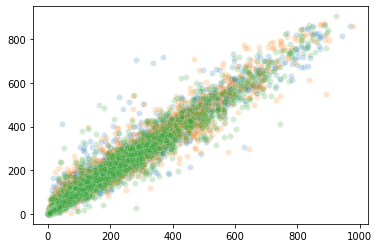

In [99]:
for pair in pair_real_prediction:
    ax = sns.scatterplot(x = pair['real'], y = pair['pred'], alpha = 0.2)
    plt.xlabel("")
    print(mean_squared_log_error(pair["real"], pair["pred"]))

### Teste

In [102]:
df_test_pipe = pipeline(df_test)
X_test = df_test_pipe[feature_cols]
test_predictions = [model.predict(X_test) for model in models]
test_yhat = np.array(predictions).mean(axis = 0)
test_predictions = pd.DataFrame(yhat, columns = ["count"], index = df_test_pipe.index)
mean_squared_log_error(df_test_pipe["count"], test_yhat)



0.12239758683428849

### Kaggle Submission

In [103]:
df_submission = pd.read_csv("test.csv") 
df_submission = pipeline(df_submission)

In [104]:
X_test = df_submission[feature_cols]
sub_predictions = [model.predict(X_test) for model in models]
sub_yhat = np.array(predictions).mean(axis = 0)
sub_predictions = pd.DataFrame(yhat, columns = ["count"], index = df_test_pipe.index)

In [112]:
sub_predictions.reset_index().to_csv(f"submissions/submission_{datetime.timestamp(datetime.now())}.csv", index=False)